In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict
from sklearn.model_selection import KFold

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 50)

# Movielens data

In [2]:
ml_ratings_df = pd.read_csv(os.path.join("data", "movielens_small", "ratings.csv")).rename(columns={'userId': 'user_id', 'movieId': 'item_id'})
ml_movies_df = pd.read_csv(os.path.join("data", "movielens_small", "movies.csv")).rename(columns={'movieId': 'item_id'})
ml_df = pd.merge(ml_ratings_df, ml_movies_df, on='item_id')
print("Number of movies: {}".format(len(ml_movies_df)))
print("Number of users: {}".format(len(ml_ratings_df.user_id.unique())))
print("Number of interactions: {}".format(len(ml_ratings_df)))
print()
print("Movies")
display(ml_movies_df.head(10))
print("Interactions")
display(ml_ratings_df.head(30))

Number of movies: 9742
Number of users: 610
Number of interactions: 100836

Movies


,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Interactions


,user_id,item_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


# Steam data

In [3]:
steam_df = pd.read_csv(os.path.join("data", "steam", "steam-200k.csv"), header=None, 
                       names=['user_id', 'game_title', 'behavior_name', 'value', 'zero']).drop(columns='zero')
print("Number of records: {}".format(len(steam_df)))
display(steam_df.head(10))

Number of records: 200000


,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
5,151603712,Spore,play,14.9
6,151603712,Fallout New Vegas,purchase,1.0
7,151603712,Fallout New Vegas,play,12.1
8,151603712,Left 4 Dead 2,purchase,1.0
9,151603712,Left 4 Dead 2,play,8.9


# Hotel data

In [4]:
hotel_original_data = pd.read_csv(os.path.join("data", "hotel_data", "hotel_data_original.csv"))
print("Number of records: {}".format(len(hotel_original_data)))
display(hotel_original_data.head(30))

Number of records: 17250


,Unnamed: 0,reservation_id,group_id,room_id,room_group_id,date_from,date_to,booking_date,booking_time,n_people,n_children_1,n_children_2,n_children_3,discount,accommodation_price,meal_price,service_price,paid,rate_plan,client_id,client_name,email,phone,is_company,reservation_status
0,0,14160,NaN,135,135,2017-09-01,2018-03-30,2017-07-04,2017-07-04 10:52:00,1,0,0,0,NaN,0.00,0.0,0.0,0.00,Standard,51665,86bd787ca115281ad9642c5fd6e79e6f2d87841c2fd9c6...,NaN,NaN,0,1
1,1,16075,NaN,118,118,2018-02-10,2018-02-12,2017-08-17,2017-08-17 15:01:00,5,0,0,0,NaN,992.29,0.0,0.0,1.00,Standard,54117,ca83ddae9b7d15212b5391c815a689b8acfd8ef31d0d80...,NaN,318faec979ecaf8adaee0c8e5d7531a67f309b7247d30b...,0,1
2,2,16076,NaN,270,270,2018-02-28,2018-03-02,2017-08-17,2017-08-17 15:08:00,4,0,0,0,0.0,693.40,0.0,0.0,693.40,Standard,54118,4db36724fc28085e053a3003dce55368ee207cce37d355...,f9c0564c66d6a830c4964a30ac261038dd7cf762b0641c...,cb550ba6d303bf230379073bcbdd55c37229eab3f173dc...,0,2
3,3,16635,NaN,294,294,2018-02-14,2018-02-15,2017-08-29,2017-08-29 13:58:00,2,0,0,0,NaN,366.80,0.0,0.0,1.00,Standard,54790,e41ecdb28a96d0b3e294aea6e854d8dc39a1d61bb3dfe4...,f6a8c77530865b7e437eb746c3564c4cbdc522c10d35f6...,1c56315c10c9d8153ca7820648900befbd9109fb6cfb81...,0,1
4,4,16964,NaN,183,183,2018-02-03,2018-02-09,2017-09-04,2017-09-04 15:52:00,4,0,0,0,NaN,1064.60,0.0,0.0,1.00,Standard,55177,5380adccf08ea3000791aad3ccc478e3b6a8de440910aa...,6d08a7230580a09f1fde268bb7c1a5d74a55bdcc9183f8...,3aff5ce689580e51de899de8ec75e8a8eaa470e4e99df4...,0,1
5,5,17173,NaN,64,64,2018-01-29,2018-02-02,2017-09-07,2017-09-07 13:21:00,2,0,0,0,NaN,713.00,0.0,0.0,1.00,Standard,55412,4aebfe125cf6c059588792b9fb871afe282a8806299dfe...,0d6aafda88cc3d5844da8c60ca9d1b6682f1ce1a4dfe12...,ea16c664798581a9d93a3128d772b8b89e05743edbbfae...,0,1
6,6,17308,NaN,111,111,2018-03-28,2018-03-31,2017-09-11,2017-09-11 10:31:00,5,0,0,0,0.0,800.00,0.0,0.0,800.00,Standard,55560,1f4b60816f6efcb45dfa67da7a6adab42d4a05b90a9278...,6163ca5013b2bc940219a59d0e30ec401ecd01bb498e03...,516b31d7892e1b5f4b6078ea0fc4c63a06bb9ceceb885d...,0,4
7,7,120165,NaN,162,162,2018-11-16,2018-11-17,2018-02-19,2018-02-19 17:44:00,5,0,0,0,0.0,402.00,0.0,0.0,402.00,Standard,63419,d47bcb623e5031df97cd9faf472e28d9fe40f1386bbd92...,5213ac7a6db98631330ac74a241ffdf840e1857481a0b5...,6416a3bc7ea31b09ae63628a143b160d7976978cdbd298...,0,4
8,8,120183,NaN,45,45,2018-08-16,2018-08-18,2018-02-19,2018-02-19 17:44:00,1,0,0,0,0.0,660.00,0.0,0.0,660.00,Standard,61777,f02a11d6b6f5bd1bf1a003a655d1c28df9362c7f2f74be...,NaN,NaN,0,4
9,9,120184,NaN,64,64,2018-08-17,2018-08-18,2018-02-19,2018-02-19 17:44:00,1,0,0,0,0.0,320.00,0.0,0.0,320.00,Standard,61778,364e80d6c0608116ff8808b339ff25dc2e3f8f2211ba38...,NaN,NaN,0,4


In [5]:
hotel_data_interactions_df = pd.read_csv(os.path.join("data", "hotel_data", "hotel_data_interactions_df.csv"))
print("Number of records: {}".format(len(hotel_data_interactions_df)))
display(hotel_data_interactions_df.head(30))

Number of records: 15268


,Unnamed: 0,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],False
1,1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# Test recommenders

## Load a sample of Movielens data

In [6]:
# Filter the data to reduce the number of movies

ml_ratings_df = pd.read_csv(os.path.join("data", "movielens_small", "ratings.csv")).rename(columns={'userId': 'user_id', 'movieId': 'item_id'})
ml_movies_df = pd.read_csv(os.path.join("data", "movielens_small", "movies.csv")).rename(columns={'movieId': 'item_id'})
ml_df = pd.merge(ml_ratings_df, ml_movies_df, on='item_id')

seed = 6789
rng = np.random.RandomState(seed=seed)
left_ids = rng.choice(ml_movies_df['item_id'], size=1000, replace=False)

ml_ratings_df = ml_ratings_df.loc[ml_ratings_df['item_id'].isin(left_ids)]
ml_movies_df = ml_movies_df.loc[ml_movies_df['item_id'].isin(left_ids)]
ml_df = ml_df.loc[ml_df['item_id'].isin(left_ids)]

print("Number of left interactions: {}".format(len(ml_ratings_df)))

Number of left interactions: 9692


## Train several recommenders

In [7]:
from recommenders.basic_recommenders import RandomRecommender
from recommenders.basic_recommenders import MostPopularRecommender
from recommenders.basic_recommenders import HighestRatedRecommender
from recommenders.tfidf_recommender import TFIDFRecommender
from recommenders.nearest_neighbors_recommender import ItemBasedCosineNearestNeighborsRecommender
from recommenders.amazon_recommender import AmazonRecommender
from recommenders.netflix_recommender import NetflixRecommender
from recommenders.gmf_recommenders import GMFRecommender

random_recommender = RandomRecommender()
most_popular_recommender = MostPopularRecommender()
highest_rated_recommender = HighestRatedRecommender()
tfidf_recommender = TFIDFRecommender()
ibcnn_recommender = ItemBasedCosineNearestNeighborsRecommender(n_neighbors=30)
amazon_recommender = AmazonRecommender()
netflix_recommender = NetflixRecommender(print_type='live', embedding_dim=8, n_epochs=20)
gmf_recommender = GMFRecommender(print_type='live', n_neg_per_pos=10, batch_size=16, 
                                 embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=5, seed=1)

In [8]:
random_recommender.fit(ml_ratings_df, None, ml_movies_df)

In [9]:
most_popular_recommender = MostPopularRecommender()
highest_rated_recommender = HighestRatedRecommender()
most_popular_recommender.fit(ml_ratings_df, None, ml_movies_df)

In [10]:
highest_rated_recommender.fit(ml_ratings_df, None, ml_movies_df)

In [11]:
tfidf_recommender.fit(ml_ratings_df, None, ml_movies_df)

In [12]:
ibcnn_recommender.fit(ml_ratings_df, None, ml_movies_df)

In [13]:
amazon_recommender.fit(ml_ratings_df, None, ml_movies_df)

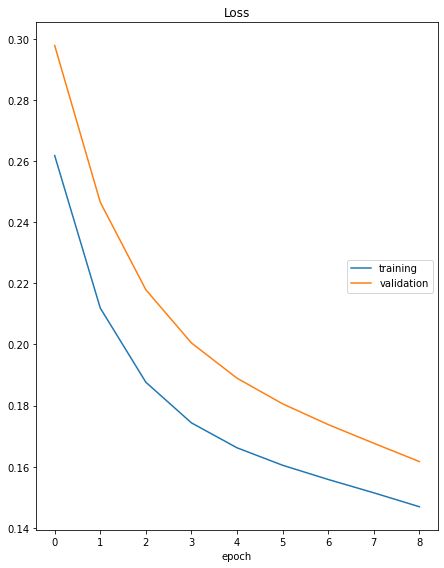

In [ ]:
netflix_recommender.fit(ml_ratings_df, None, ml_movies_df)

In [ ]:
gmf_recommender.fit(ml_ratings_df, None, ml_movies_df)

In [ ]:
recommenders = [random_recommender, most_popular_recommender, highest_rated_recommender, tfidf_recommender, 
                ibcnn_recommender, amazon_recommender, netflix_recommender, gmf_recommender]

## Take a look on user 6 preferences

In [ ]:
# Print movies watched by user 6

active_user_movies = ml_df.loc[ml_df['user_id'] == 6]
print("Active user history")
display(active_user_movies.sort_values('rating', ascending=False))

## Generate recommendations

In [ ]:
for recommender in recommenders:
    recommendations = recommender.recommend(pd.DataFrame([[6]], columns=['user_id']), ml_movies_df, 5)

    recommendations = pd.merge(recommendations, ml_movies_df, on='item_id', how='left')
    print("Recommendations for {}".format(type(recommender).__name__))
    display(recommendations)

### Train-test split test

In [ ]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

random_recommender = RandomRecommender()
most_popular_recommender = MostPopularRecommender()
highest_rated_recommender = HighestRatedRecommender()
tfidf_recommender = TFIDFRecommender()
ibcnn_recommender = ItemBasedCosineNearestNeighborsRecommender(n_neighbors=30)
amazon_recommender = AmazonRecommender()
netflix_recommender = NetflixRecommender(print_type=None, embedding_dim=8, n_epochs=20)
gmf_recommender = GMFRecommender(print_type=None, n_neg_per_pos=10, batch_size=16, 
                                 embedding_dim=6, lr=0.001, weight_decay=0.0001, n_epochs=5, seed=1)

recommenders = [random_recommender, most_popular_recommender, highest_rated_recommender, tfidf_recommender, 
                ibcnn_recommender, amazon_recommender, netflix_recommender, gmf_recommender]

all_results = []

for recommender in recommenders:
    results = [[type(recommender).__name__] + list(evaluate_train_test_split_implicit(
        recommender, ml_ratings_df, ml_movies_df))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])
    all_results.append(results)

    display(results)
    
all_results = pd.concat(all_results).reset_index(drop=True)
display(all_results)